#**Cài đặt và import thư viện**

In [ ]:
!pip install underthesea

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from PIL import Image
from collections import Counter
from google.colab import drive
from underthesea import word_tokenize
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/vqa/data_fruits'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Các tham số Hyperparameters
VOCAB_SIZE = 0
BATCH_SIZE = 8
EMBED_SIZE = 128
HIDDEN_SIZE = 256
LR = 2e-5
NUM_EPOCHS = 30
IMG_SIZE = 224
MODEL_PATH = "/content/drive/MyDrive/vqa/best_vqa_model.pth"
# --- DICTIONARY FOR TRANSLATION ---
FRUIT_DICT = {
    "apple": "quả táo",
    "orange": "quả cam",
    "avocado": "quả bơ",
    "blueberry": "quả việt quất",
    "cherry": "quả cherry",
    "kiwi": "quả kiwi",
    "mango": "quả xoài",
    "strawberry": "dâu tây",
}
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


cuda


#**Chuẩn bị dữ liệu**

##**Xây dựng từ điển**

In [ ]:
class Vocabulary:
  def __init__(self):
    self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
    self.freq_threshold = 1

  def __len__(self):
    return len(self.word2idx)

  def build_vocabulary(self, sentence_list):
    frequencies = Counter()
    idx = 4
    for sentence in sentence_list:
      for word in sentence.lower().split():
        frequencies[word] += 1
        if frequencies[word] == self.freq_threshold:
          self.word2idx[word] = idx
          self.idx2word[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = text.lower().split()
    return [
        self.word2idx.get(token, self.word2idx["<unk>"])
        for token in tokenized_text
    ]

In [ ]:
def load_fruit_data(root_dir, split = 'train'):
  data_samples = []
  if not os.path.exists(root_dir):
    print("Không tìm thấy đường dẫn")
    return []

  split_dir_path = os.path.join(root_dir, split)

  if not os.path.exists(split_dir_path):
    print("Không tìm thấy đường dẫn")
    return []

  classes = [d for d in os.listdir(split_dir_path) if os.path.join(split_dir_path, d)]
  for en_name in classes:
    class_dir = os.path.join(split_dir_path, en_name)
    possible_img_dirs = [
        os.path.join(class_dir, 'images'),
        class_dir
    ]

    target_img_dir = None
    for d in possible_img_dirs:
      if os.path.exists(d) and any(f.lower().endswith(('.jpg', '.png', '.jpeg')) for f in os.listdir(d)):
        target_img_dir = d
        break

    if target_img_dir is None:
      continue

    vn_name = FRUIT_DICT.get(en_name.lower(), en_name)

    for img_name in os.listdir(target_img_dir):
      if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(target_img_dir, img_name)

        qa_pairs = [
            ("Đây là quả gì", vn_name),
            ("Quả gì đây", vn_name),
            ("Trong ảnh là quả gì", vn_name)
        ]

        for q, a in qa_pairs:
          data_samples.append({
              "image": img_path,
              "question": q,
              "answer": a
          })

  return data_samples


#**Dataset**

In [ ]:
class FruitVQADataset(Dataset):
    def __init__(self, data_list, vocab, transform=None):
        self.data = data_list
        self.transform = transform
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        img_path = item["image"]
        question = item["question"]
        answer = item["answer"]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        q_vec = [self.vocab.word2idx["<sos>"]] + self.vocab.numericalize(question) + [self.vocab.word2idx["<eos>"]]
        a_vec = [self.vocab.word2idx["<sos>"]] + self.vocab.numericalize(answer) + [self.vocab.word2idx["<eos>"]]

        return image, torch.tensor(q_vec), torch.tensor(a_vec)

In [ ]:
def MyCollate(batch):
  data = [item[0] for item in batch ]
  imgs = torch.stack(data, 0)

  questions = [item[1] for item in batch]
  answers = [item[2] for item in batch]

  questions = pad_sequence(questions, batch_first=True, padding_value = 0)
  answers = pad_sequence(answers, batch_first = True, padding_value = 0)

  return imgs, questions, answers

In [ ]:
train_data = load_fruit_data(data_path, split = "train")
val_data = load_fruit_data(data_path, split = "val")
test_data = load_fruit_data(data_path, split = "test")

all_text = [i['question'] for i in train_data] + [i['answer'] for i in train_data]
vocab = Vocabulary()
vocab.build_vocabulary(all_text)

train_dataset = FruitVQADataset(train_data, vocab, transform=transform)
val_dataset = FruitVQADataset(val_data, vocab, transform=transform)
test_dataset = FruitVQADataset(test_data, vocab, transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MyCollate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MyCollate)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MyCollate)


#**CNN**

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, embed_dim):
        super(CNNEncoder, self).__init__()
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        for param in resnet.parameters():
            param.requires_grad = False

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.fc(features)
        features = self.bn(features)
        return features


#**LSTM**

In [ ]:
class LSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(embed_dim * 2, hidden_dim)
        self.init_c = nn.Linear(embed_dim * 2, hidden_dim)

    def forward(self, img_features, q_features, captions):
        embeddings = self.embedding(captions)
        combined = torch.cat([img_features, q_features], dim=1)
        h0 = self.init_h(combined).unsqueeze(0)
        c0 = self.init_c(combined).unsqueeze(0)
        outputs, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(outputs)
        return outputs

#**VQA Model**

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(VQAModel, self).__init__()
        self.cnn = CNNEncoder(embed_dim)
        self.q_emb = nn.Embedding(vocab_size, embed_dim)
        self.q_lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
        self.decoder = LSTMDecoder(embed_dim, hidden_dim, vocab_size)

    def forward(self, images, questions, answers):
        img_feat = self.cnn(images)
        q_emb = self.q_emb(questions)
        _, (q_h, _) = self.q_lstm(q_emb)
        q_feat = q_h[-1]
        outputs = self.decoder(img_feat, q_feat, answers)
        return outputs

In [ ]:
model = VQAModel(len(train_dataset.vocab), EMBED_SIZE, HIDDEN_SIZE).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
def val_model(model, val_loader, criterion, optimizer, num_epochs, device, dataset):
  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for imgs, questions, answers in val_loader:
          imgs, questions, answers = imgs.to(device), questions.to(device), answers.to(device)

          outputs = model(imgs, questions, answers[:, :-1])
          targets = answers[:, 1:]

          loss = criterion(outputs.reshape(-1, len(dataset.vocab)), targets.reshape(-1))
          val_loss += loss.item()

          preds = torch.argmax(outputs, dim=2)
          mask = targets != 0
          val_correct += ((preds == targets) & mask).sum().item()
          val_total += mask.sum().item()

  avg_val_loss = val_loss / len(val_loader)
  avg_val_acc = val_correct / val_total if val_total > 0 else 0

  return avg_val_loss, avg_val_acc

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, dataset, patience=5, save_dir="checkpoints"):
    # Tạo thư mục lưu model nếu chưa có
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Bắt đầu train với Early Stopping (Patience={patience})...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

        for imgs, questions, answers in loop:
            imgs, questions, answers = imgs.to(device), questions.to(device), answers.to(device)

            outputs = model(imgs, questions, answers[:, :-1])
            targets = answers[:, 1:]
            loss = criterion(outputs.reshape(-1, len(dataset.vocab)), targets.reshape(-1))

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Accuracy
            preds = torch.argmax(outputs, dim=2)
            mask = targets != 0
            train_correct += ((preds == targets) & mask).sum().item()
            train_total += mask.sum().item()

            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total if train_total > 0 else 0


        avg_val_loss, avg_val_acc = val_model(model, val_loader, criterion, optimizer, num_epochs, device, dataset)

        # Lưu history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")


        # Nếu Val Loss giảm
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Lưu model tốt nhất
            best_model_path = os.path.join(save_dir, "best_vqa_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Đã lưu Best Model (Loss giảm xuống {best_val_loss:.4f})")
        else:
            # Nếu không giảm
            epochs_no_improve += 1
            print(f"Val Loss không giảm ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print(f"Dừng! Model không cải thiện trong {patience} epochs liên tiếp.")
                break

    # Lưu model cuối cùng
    last_model_path = os.path.join(save_dir, "last_vqa_model.pth")
    torch.save(model.state_dict(), last_model_path)
    print("Hoàn tất huấn luyện.")

    return history

In [ ]:
def visualize_history(history):
    """
    Hàm vẽ biểu đồ Loss và Accuracy từ biến history
    """
    # Lấy dữ liệu
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_acc']
    val_acc = history['val_acc']

    epochs = range(1, len(train_loss) + 1)

    # Thiết lập khung hình
    plt.figure(figsize=(15, 6))

    # Hàm biểu đồ mất mát
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-s', label='Validation Loss')
    plt.title('Biểu đồ Loss (Càng thấp càng tốt)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Hàm biểu đồ chính xác
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-s', label='Validation Accuracy')
    plt.title('Biểu đồ Accuracy (Càng cao càng tốt)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Bắt đầu train với Early Stopping (Patience=5)...


Epoch 1: Train Loss: 2.5714 | Train Acc: 0.5303 | Val Loss: 1.8750 | Val Acc: 0.6261
Đã lưu Best Model (Loss giảm xuống 1.8750)


Epoch 2: Train Loss: 1.3727 | Train Acc: 0.6171 | Val Loss: 0.9900 | Val Acc: 0.7159
Đã lưu Best Model (Loss giảm xuống 0.9900)


Epoch 3: Train Loss: 0.8732 | Train Acc: 0.7849 | Val Loss: 0.6798 | Val Acc: 0.8391
Đã lưu Best Model (Loss giảm xuống 0.6798)


Epoch 4: Train Loss: 0.6188 | Train Acc: 0.8506 | Val Loss: 0.5114 | Val Acc: 0.8841
Đã lưu Best Model (Loss giảm xuống 0.5114)


Epoch 5: Train Loss: 0.4800 | Train Acc: 0.8811 | Val Loss: 0.4069 | Val Acc: 0.8942
Đã lưu Best Model (Loss giảm xuống 0.4069)


Epoch 6: Train Loss: 0.3964 | Train Acc: 0.8953 | Val Loss: 0.3383 | Val Acc: 0.9246
Đã lưu Best Model (Loss giảm xuống 0.3383)


Epoch 7: Train Loss: 0.3525 | Train Acc: 0.9010 | Val Loss: 0.2980 | Val Acc: 0.9246
Đã lưu Best Model (Loss giảm xuống 0.2980)


Epoch 8: Train Loss: 0.3094 | Train Acc: 0.9133 | Val Loss: 0.2465 | Val Acc: 0.9406
Đã lưu Best Model (Loss giảm xuống 0.2465)


Epoch 9: Train Loss: 0.2728 | Train Acc: 0.9250 | Val Loss: 0.2322 | Val Acc: 0.9449
Đã lưu Best Model (Loss giảm xuống 0.2322)


Epoch 10: Train Loss: 0.2452 | Train Acc: 0.9326 | Val Loss: 0.1966 | Val Acc: 0.9507
Đã lưu Best Model (Loss giảm xuống 0.1966)


Epoch 11: Train Loss: 0.2290 | Train Acc: 0.9346 | Val Loss: 0.1912 | Val Acc: 0.9536
Đã lưu Best Model (Loss giảm xuống 0.1912)


Epoch 12: Train Loss: 0.2124 | Train Acc: 0.9376 | Val Loss: 0.1696 | Val Acc: 0.9609
Đã lưu Best Model (Loss giảm xuống 0.1696)


Epoch 13: Train Loss: 0.2075 | Train Acc: 0.9381 | Val Loss: 0.1736 | Val Acc: 0.9493
Val Loss không giảm (1/5)


Epoch 14: Train Loss: 0.1870 | Train Acc: 0.9425 | Val Loss: 0.1623 | Val Acc: 0.9464
Đã lưu Best Model (Loss giảm xuống 0.1623)


Epoch 15: Train Loss: 0.1761 | Train Acc: 0.9476 | Val Loss: 0.1578 | Val Acc: 0.9609
Đã lưu Best Model (Loss giảm xuống 0.1578)


Epoch 16: Train Loss: 0.1669 | Train Acc: 0.9481 | Val Loss: 0.1626 | Val Acc: 0.9507
Val Loss không giảm (1/5)


Epoch 17: Train Loss: 0.1596 | Train Acc: 0.9494 | Val Loss: 0.1443 | Val Acc: 0.9594
Đã lưu Best Model (Loss giảm xuống 0.1443)


Epoch 18: Train Loss: 0.1475 | Train Acc: 0.9538 | Val Loss: 0.1395 | Val Acc: 0.9594
Đã lưu Best Model (Loss giảm xuống 0.1395)


Epoch 19: Train Loss: 0.1414 | Train Acc: 0.9535 | Val Loss: 0.1370 | Val Acc: 0.9623
Đã lưu Best Model (Loss giảm xuống 0.1370)


Epoch 20: Train Loss: 0.1409 | Train Acc: 0.9530 | Val Loss: 0.1301 | Val Acc: 0.9667
Đã lưu Best Model (Loss giảm xuống 0.1301)


Epoch 21: Train Loss: 0.1317 | Train Acc: 0.9595 | Val Loss: 0.1419 | Val Acc: 0.9507
Val Loss không giảm (1/5)


Epoch 22: Train Loss: 0.1312 | Train Acc: 0.9548 | Val Loss: 0.1340 | Val Acc: 0.9580
Val Loss không giảm (2/5)


Epoch 23: Train Loss: 0.1212 | Train Acc: 0.9573 | Val Loss: 0.1204 | Val Acc: 0.9652
Đã lưu Best Model (Loss giảm xuống 0.1204)


Epoch 24: Train Loss: 0.1199 | Train Acc: 0.9575 | Val Loss: 0.1128 | Val Acc: 0.9580
Đã lưu Best Model (Loss giảm xuống 0.1128)


Epoch 25: Train Loss: 0.1141 | Train Acc: 0.9592 | Val Loss: 0.1198 | Val Acc: 0.9696
Val Loss không giảm (1/5)


Epoch 26: Train Loss: 0.1184 | Train Acc: 0.9562 | Val Loss: 0.1188 | Val Acc: 0.9580
Val Loss không giảm (2/5)


Epoch 27: Train Loss: 0.1211 | Train Acc: 0.9533 | Val Loss: 0.0987 | Val Acc: 0.9623
Đã lưu Best Model (Loss giảm xuống 0.0987)


Epoch 28: Train Loss: 0.1019 | Train Acc: 0.9616 | Val Loss: 0.1094 | Val Acc: 0.9667
Val Loss không giảm (1/5)


Epoch 29: Train Loss: 0.1077 | Train Acc: 0.9595 | Val Loss: 0.1151 | Val Acc: 0.9681
Val Loss không giảm (2/5)


Epoch 30: Train Loss: 0.1043 | Train Acc: 0.9600 | Val Loss: 0.1197 | Val Acc: 0.9580
Val Loss không giảm (3/5)
Hoàn tất huấn luyện.


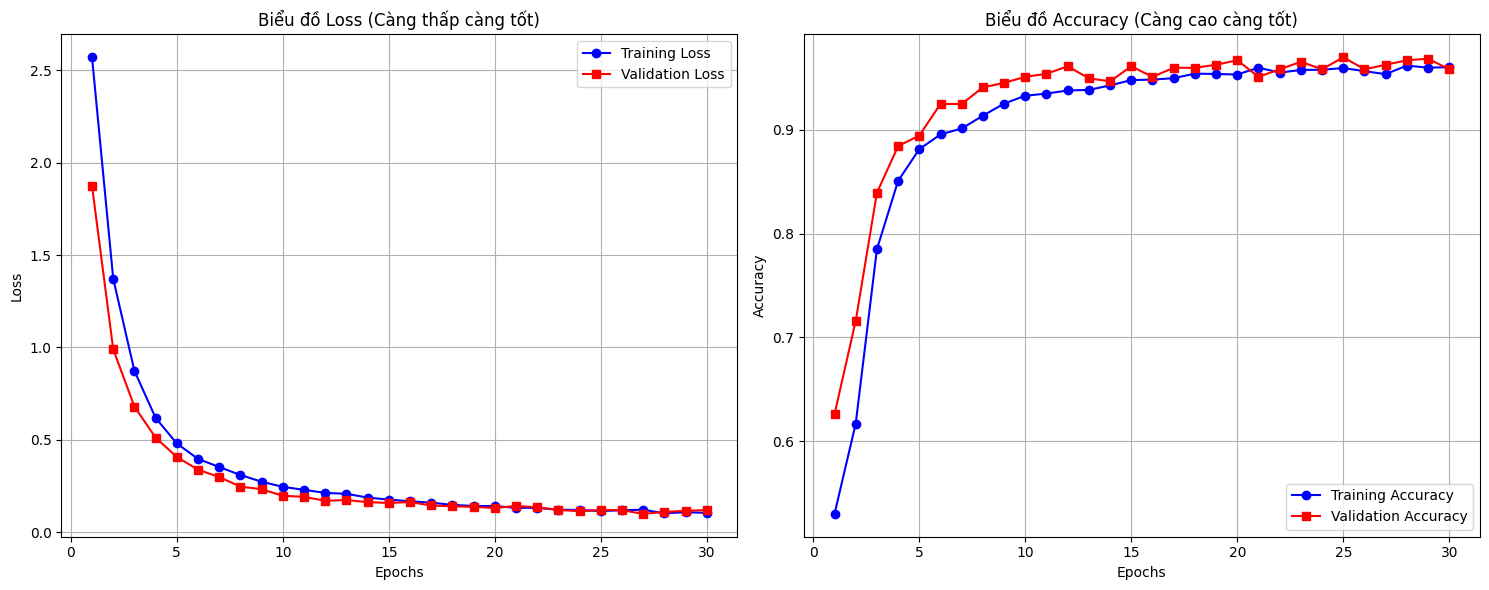

In [ ]:
history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, NUM_EPOCHS, device, train_dataset, patience=5, save_dir="checkpoints")
visualize_history(history)

In [ ]:
model.load_state_dict(torch.load("checkpoints/best_vqa_model.pth", map_location=device))

<All keys matched successfully>

In [ ]:
def inference(model, img_path, question):
  model.eval()

  try:
      img = Image.open(img_path).convert("RGB")
      img_tensor = transform(img).unsqueeze(0).to(device)

      q_vec = [1] + test_dataset.vocab.numericalize(question) + [2]
      q_tensor = torch.tensor(q_vec).unsqueeze(0).to(device)

      with torch.no_grad():
          img_feat = model.cnn(img_tensor)
          q_emb = model.q_emb(q_tensor)
          _, (q_h, _) = model.q_lstm(q_emb)
          q_feat = q_h[-1]

          combined = torch.cat((img_feat, q_feat), dim=1)
          h = model.decoder.init_h(combined).unsqueeze(0)
          c = model.decoder.init_c(combined).unsqueeze(0)

          inputs = torch.tensor([1]).to(device).unsqueeze(0)
          result_words = []

          for _ in range(10):
              emb = model.decoder.embedding(inputs)
              out, (h, c) = model.decoder.lstm(emb, (h, c))
              pred = model.decoder.linear(out.squeeze(1)).argmax(1).item()

              if pred == 2: break
              result_words.append(test_dataset.vocab.idx2word[pred])
              inputs = torch.tensor([pred]).to(device).unsqueeze(0)

      print(f"Image: {img_path}")
      print(f"Question: {real_question}")
      print(f"Answer: {' '.join(result_words)}")

  except Exception as e:
      print(f"Error during inference: {e}")

In [ ]:
idx = random.randint(0, len(test_dataset)-1)
img_path = test_dataset.data[idx]["image"]
real_question = "Đây là quả gì"
inference(model, img_path, real_question)

Image: /content/drive/MyDrive/vqa/data_fruits/test/cherry/images/8d0f89b8504387af6c815ce75c9337115c51c6ea2ec11_1260x1260_jpg.rf.8d91812aa6b7695512c623e6ac662ea2.jpg
Question: Đây là quả gì
Answer: quả cherry
